In [28]:
# reload magics
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from math import log10

# from project_modules.utils import get_logger
# logger = get_logger("log-data-umap.log")
# read the parameter file


# palette - map the cluster labels to a color
import colorcet as cc

palette = cc.glasbey_hv

colours = {i: palette[i] for i in range(len(cc.glasbey_hv))}
colours

colours[-1] = "gray"

from project_modules.utils import read_parameters
parms = read_parameters("/Users/david/projects/lc-project-data/project.yaml")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# make blobs using sklearn
from sklearn.datasets import make_blobs, make_classification
from sklearn.preprocessing import StandardScaler, MinMaxScaler

SAMPLES = 1_000
FEATURES = 25

# make blobs
X, y = make_classification(n_samples=SAMPLES, 
                            n_features=FEATURES, 
                            n_informative = 5,
                            random_state=42,
                            n_classes=3,
                            class_sep=2.5,
                            # flip_y=0.25,
                            )


# scale the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)



# make a 2d plot of the blobs

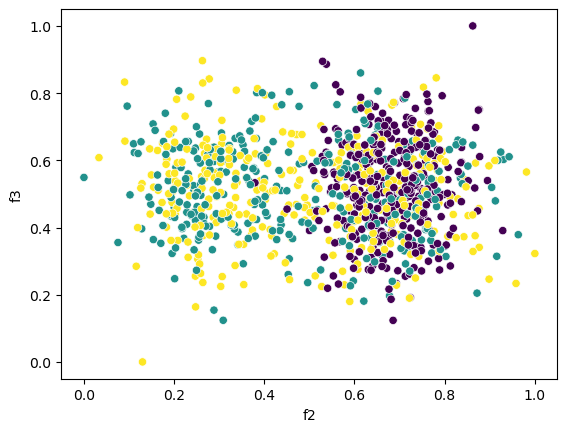

In [30]:
# plot the first two features on a sns scatter plot
df = pd.DataFrame(X, columns=[f"f{i}" for i in range(FEATURES)])
# df["label"] = y
# df["label"] = df["label"].astype("category")

# plot the first two features
sns.scatterplot(data=df, x="f2", y="f3", c = y)
plt.show()

In [31]:
# split the synetetic data into a train set, test set, and holdout set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [54]:
# fit a umap model to the training data
import umap
umap_model = umap.UMAP(
                        # n_neighbors=50, 
                        n_components=2, 
                        # metric = "euclidean",
                        # min_dist=0.1
                         )
umap_model.fit(X_train)


# transform the training data
X_train_umap = umap_model.transform(X_train)
X_train_tsne = tsne_model.fit_transform(X_train)

# use hdbscan clustering to label the training data
import hdbscan
clusterer = hdbscan.HDBSCAN(
                                min_cluster_size=50, 
                                min_samples=5, 
                                prediction_data=True, 
                                cluster_selection_method="leaf"
                            )

# clusterer.fit(X_train_umap)
clusterer.fit(X_train_tsne)

df_train = pd.DataFrame(X_train_umap, columns=["dim1", "dim2"])
df_train["true_label"] = y_train
df_train["cluster"] = clusterer.labels_


<Axes: xlabel='dim1', ylabel='dim2'>

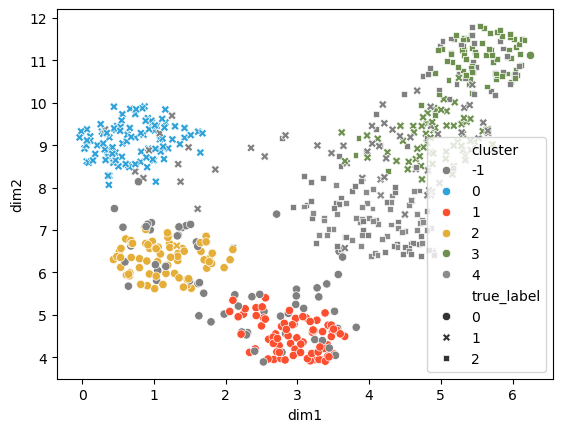

In [55]:
sns.scatterplot(data=df_train, x="dim1", y="dim2", hue="cluster", style = "true_label", palette = colours)

In [62]:

# apply the same umap_mdel to the test data and predict cluster membership
X_test_umap = umap_model.transform(X_test)

y_test_pred = np.argmax(hdbscan.prediction.membership_vector(clusterer, X_test_umap), axis = 1)

test_n = len(np.unique(y_holdout))

# apply the same umap_mdel to the holdout data and predict cluster membership
X_holdout_umap = umap_model.transform(X_holdout)


# assign the most likely cluster
y_holdout_pred = np.argmax(hdbscan.prediction.membership_vector(clusterer, X_holdout_umap), axis = 1)
holdout_n = len(np.unique(y_holdout))


df_test = pd.DataFrame(X_test_umap, columns=["dim1", "dim2"])
df_test["label"] = y_test_pred

df_holdout = pd.DataFrame(X_holdout_umap, columns=["dim1", "dim2"])
df_holdout["label"] = y_holdout_pred



In [64]:
print(f"Test: {test_n} clusters")
# sns.scatterplot(data=df_test, x="umap1", y="dim2", hue="label")

print(f"Holdout: {holdout_n} clusters")
# sns.scatterplot(data=df_holdout, x="umap1", y="dim2", hue="label")

Test: 3 clusters
Holdout: 3 clusters


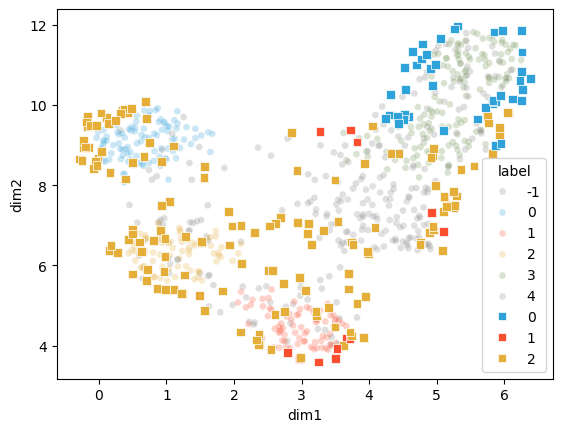

In [65]:

# plot the first two features
sns.scatterplot(data=df_train, x="dim1", y="dim2", hue="cluster", s=24, alpha=0.25, palette = colours, )


sns.scatterplot(data = df_test, x="dim1", y="dim2", marker="s", s=40, hue = "label", palette = colours)
# sns.scatterplot(data = df_holdout, x="umap1", y="dim2", hue="label", marker="^", s=10, palette=  "tab10")


plt.show()